In [1]:
import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

import findspark
findspark.init()

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [17]:
import pyspark
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

# import get_ref_info.py
import os
import sys
my_fun = '../src/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *
from operator import add
from urllib.parse import urlparse
import seaborn as sns
import numpy as np

# Loading data 

**File schema** is shown.

In [3]:
DATA_DIR = '../' 
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia_ = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
# show file schema
wikipedia_.printSchema()

root
 |-- id: long (nullable = true)
 |-- ns: long (nullable = true)
 |-- restrictions: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nulla

In [4]:
# how many articles are there?
print("Number of articles: {}".format(wikipedia_.count()))

Number of articles: 18782


---

# Article outliers removal

We have some outliers we need to deal with, as a first step we use keywords (**"war, riot, conflict, protest, revolt, operation, attack, annexation, genocide, insurgency, crisis, confrontation, clash"**) on the article titles to extract from our chosen categories (`civilian attack`, `civil conflict`, `military conflict`).

For example, we found that some articles in `civilian attack` may contain the infobox `civilian attack` but are not really a `civilian attack`. The following page 

> Fraunces Tavern: Fraunces Tavern is a landmark museum and restaurant in New York City, situated at 54 Pearl Street at the corner of Broad Street. The location played a prominent role in history before, during and after the American Revolution, serving as a headquarters for George Washington, a venue for peace negotiations with the British, and housing federal offices in the Early Republic.

Since some pages are considered **outliers**, we remove them using the method described above and remove any disambiguations.

In [5]:
# filter out outliers
outlier_regex = "war*|riot*|conflict*|protest*|revolt*|operation*|attack*|annexation*|genocide*|insurgency*|crisis*|confrontation*|clash*"
wikipedia = wikipedia_.filter(wikipedia_['title'].rlike(outlier_regex))
print("Number of articles without outliers: {}".format(wikipedia.count()))

wikipedia = wikipedia.filter("lower(revision.text._VALUE) not like '%{disambiguation}%'")
# save in parquet
wikipedia.write.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")
# load from parquet so that the rest of notebook uses cleaned version of data
wikipedia = spark.read.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")

Number of articles without outliers: 1788


We explore how many articles have each **keyword** selected in the given keywords. 

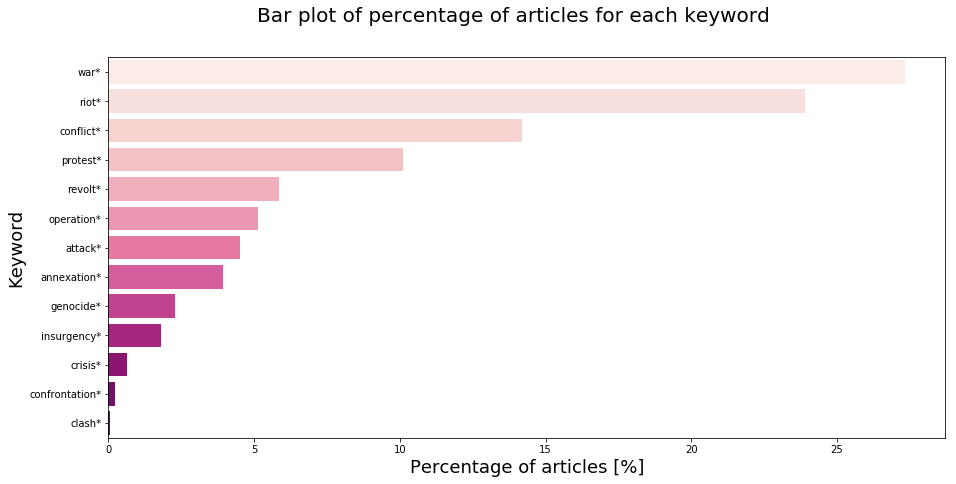

In [51]:
keyword_wikipedia = spark.read.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")

titles = outlier_regex.split('|')

titles_count = pd.DataFrame(np.zeros((len(titles), )), index=titles, columns=['count'])
# computationally less expansive
wiki_titles = keyword_wikipedia.select('title')

# count the titles that contains titles
for ele in titles:
    titles_count.loc[ele] = wiki_titles.filter(wiki_titles.title.rlike(ele)).count()

    
titles_count['count'] = titles_count['count']*100/titles_count['count'].sum()  
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(
    x='count', y=titles_count.index, data=titles_count.sort_values('count', ascending=False), 
    orient='h', palette="RdPu"
);

plt.xlabel('Percentage of articles [%]',fontsize=18)
plt.ylabel('Keyword',fontsize=18)
f.suptitle('Bar plot of percentage of articles for each keyword', fontsize=20)
f.set_size_inches(15, 7)
plt.show()

**Bar plot of percentage of articles for each keyword.** 

We can see that the keyword `war, riot` together make up for ~50% of the articles. Very little articles are associated to `clash` or `confrontation`.

---
# Quantifying *importance* of each page in each category

We want to see how *important* each page is in each category. As we are solely focusing on *'war'*-related subjects in this pilot phase, we define *page importance* by the number of deaths. 

## Infobox or Wikidata per category 

Functions `get_wiki_civilian_attack`, `get_wiki_military_conflict`
to get relevant information and views for each category: `civilian attack`, `military conflict`. 
Data is obtained either using the page's wikidata is the data exists or acquired through infobox parsing.
Relevant information is chosen based on the fields found on [List of infoboxes and fields](https://en.wikipedia.org/wiki/Wikipedia:List_of_infoboxes#Event) 

Extract info for each category in **Infobox**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * place
    * date 
    * casualities1
* `civil conflict`
    * place
    * date 
    * casualities1
    
Extract info for each category in **Wikidata**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
* `civil conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
    
We use an external library [wptools wiki](https://github.com/siznax/wptools/wiki) to help us parse the data. 

### Categories
We focus on categories : `civilian attack`, `military conflict`, `civil conflict` from our pre-filtered wikipedia dump data which had 3 categories: `civilian attack`, `military conflict`, `civil conflict` (key words we used via regex expression to extract articles containing infoboxes with such headers by parsing the revision.text.__VALUE). 

We also found a list of all ongoing civil wars listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars) have a `Template:Infobox military`. This may be of interest in a later step.

[List of ongoing civil wars](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars):
 * Myanmar, Internal conflict in Myanmar, since 1948
 * Indonesia, Papua conflict, since 1962
 * Colombia, Colombian conflict, since 1964
 * Afghanistan, War in Afghanistan, since 1978
 * Turkey, Kurdish–Turkish conflict since 1978
 * Somalia, Somali Civil War, since 1988
 * Sudan, three conflicts
* War in Darfur, since 26 February 2003
* Sudanese nomadic conflicts, since 26 May 2009 through at least 2017
* Sudanese conflict in South Kordofan and Blue Nile since 5 June 2011
 * Pakistan, War in North-West Pakistan, since 16 March 2004
 * Paraguay, Paraguayan People's Army insurgency, since 2005
 * Syria, Syrian Civil War, since 15 March 2011, also see List of armed groups in the Syrian Civil War
 * Central African Republic, Central African Republic conflict, since 10 December 2012
 * South Sudan, South Sudanese Civil War, since 15 December 2013
 * Libya, Second Libyan Civil War, since 16 May 2014
 * Yemen, Second Yemeni Civil War, since 19 March 2015

In [6]:
def get_wiki_military_conflict(entity):
    page = wptools.page(entity.title)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            page.get_parse()
            info['death'] = poly_page.data['infobox']['casualties1']
        except:
            info['death'] = None
            
    try:
        page.get_wikidata()
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            page.get_parse()
            info['end_date'] = poly_page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        page.get_wikidata()
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            page.get_parse()
            info['location'] = poly_page.data['infobox']['place']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, title=entity.title, death=info['death'],
               end_date=info['end_date'], location=info['location'])

def get_wiki_civilian_attack(entity):
    page = wptools.page(entity.title)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            page.get_parse()
            info['death'] = poly_page.data['infobox']['fatalities']
        except:
            info['death'] = None
            
    try:
        page.get_wikidata()
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            page.get_parse()
            info['end_date'] = poly_page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        page.get_wikidata()
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            page.get_parse()
            info['location'] = poly_page.data['infobox']['location']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, title=entity.title, death=info['death'],
               end_date=info['end_date'], location=info['location'])

### Wikidata & Infobox `military conflict `

In [7]:
infobox_military_conflict = 'military conflict'
# find all pages that have category military conflict
wiki_military_conflict = wikipedia.where("categories like '%{}%'".format(infobox_military_conflict)) 

In [8]:
wiki_military_conflict_df = sqlContext.createDataFrame(wiki_military_conflict.rdd.map(get_wiki_military_conflict))

In [9]:
wiki_military_conflict_df.take(3)

[Row(death=None, end_date=None, id=25523989, location='Dongo, Democratic Republic of the Congo (Q3036273)', title='Dongo conflict'),
 Row(death=None, end_date=None, id=29412323, location='Turpan (Q868527)', title='Ming–Turpan conflict'),
 Row(death=None, end_date=None, id=29420770, location='Xi River (Q216941)', title='Broadway expedition')]

In [ ]:
# saving binary file to future uses
#wiki_military_conflict_df.write.parquet(DATA_DIR +"{}.parquet".format(infobox_military_conflict));
# loading the saved parquet files
#wiki_military_conflict_df_reload = spark.read.parquet(
    #DATA_DIR_FILTERED+"{}.parquet".format(infobox_military_conflict));

### Wikidata & Infobox `civilian attack`

In [10]:
infobox_civilian_attack = 'civilian attack'
# find all pages that have category civilian attack
wiki_civilian_attack = wikipedia.where("categories like '%{}%'".format(infobox_civilian_attack)) 

In [11]:
wiki_civilian_attack_df = sqlContext.createDataFrame(wiki_civilian_attack.rdd.map(get_wiki_civilian_attack))

In [12]:
wiki_civilian_attack_df.take(3)

[Row(death='+18', end_date=None, id=26349076, location='Kabul (Q5838)', title='February 2010 Kabul attack'),
 Row(death=None, end_date=None, id=22940423, location=None, title='Olowalu, Hawaii'),
 Row(death=None, end_date=None, id=51158872, location='Reutlingen (Q3085)', title='Reutlingen knife attack')]

### Wikidata & Infobox `civil conflict`

In [13]:
infobox_civil_conflict = 'civil conflict'
# find all pages that have category civilian attack
wiki_civil_conflict = wikipedia.where("categories like '%{}%'".format(infobox_civil_conflict)) 

In [14]:
wiki_civil_conflict_df = sqlContext.createDataFrame(wiki_civil_conflict.rdd.map(get_wiki_military_conflict))

In [15]:
wiki_civil_conflict_df.take(3)

[Row(death=None, end_date=None, id=29393333, location=None, title='Cincinnati riots of 1829'),
 Row(death=None, end_date=None, id=29398957, location=None, title='Helwan riots (1945)'),
 Row(death=None, end_date=None, id=29410468, location=None, title='Cincinnati riots of 1855')]

---

# Popularity Metrics

## Loading the data

In [52]:
# Loading the data
DATA_DIR = '../' 
WIKIPEDIA_REFERENCES_PARQUET = DATA_DIR + "wikipedia_no_outliers.parquet"

# loading the saved parquet files
wikipedia_ref = spark.read.parquet(WIKIPEDIA_REFERENCES_PARQUET)
wikipedia_ref.show(10)

+--------+---+------------+--------------------+--------------------+-----------------+---------------+
|      id| ns|restrictions|            revision|               title|       categories|good_categories|
+--------+---+------------+--------------------+--------------------+-----------------+---------------+
|25523989|  0|        null|[[/* Refugee cris...|      Dongo conflict|military conflict|           true|
|29393333|  0|        null|[[Remove a delete...|Cincinnati riots ...|   civil conflict|           true|
|29398957|  0|        null|[[/* Citations */...| Helwan riots (1945)|   civil conflict|           true|
|29410468|  0|        null|[[Remove a delete...|Cincinnati riots ...|   civil conflict|           true|
|29412323|  0|        null|[[Chronological o...|Ming–Turpan conflict|military conflict|           true|
|29420770|  0|        null|[[Reverted edits ...| Broadway expedition|military conflict|           true|
|26349076|  0|        null|[[Bot: [[User:Kol...|February 2010 Ka

## POPULARITY METRIC 1

### Get number of references per page

We use our pre-filtered data and we count the number of tag of type ```<ref>```, by parsing all pages to get the number of references. We think that the more *popular* a page is, the more references it will contain.

We want to see:
* how many references a page has
* what does the distribution of the references look like 
* what are the top domains across these articles 
* how many articles have a reference to each domain

The analysis is based on work from *Research:Characterizing Wikipedia Citation Usage*: [MetaPageQueries](https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis)

Example of reference format:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```

**quantify the number of references per page**
    * using regex expression to find the references in the page
    * counting the number of references

In [53]:
# quantify the number of references per page

# Compile a regular expression pattern into a regular expression object, 
#which can be used for matching using its findall.
just_ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

# find # references <ref> per page 
def get_refs_count(entity, regex_expression=just_ref_regex ):
    # get access to value in text in revision
    text = entity.revision.text._VALUE
    # find references
    refs = just_ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs), categories=entity.categories)

In [54]:
# get the # of references per page
# Creates a DataFrame from an RDD, apply counting function with regex expression
reference_count_page = sqlContext.createDataFrame(wikipedia_ref.rdd.map(get_refs_count))
reference_count_page.sort('refs_count', ascending=False).show(5)
reference_count_page_sql = reference_count_page.registerTempTable('reference_count_page_sql')

+-----------------+--------+----------+
|       categories|      id|refs_count|
+-----------------+--------+----------+
|military conflict|43243199|       609|
|military conflict| 3030955|       519|
|military conflict|56944198|       473|
|military conflict|47894039|       453|
|  civilian attack| 3177125|       449|
+-----------------+--------+----------+
only showing top 5 rows



In [55]:
# quantify the # articles with # ref > 0: 
non_zero_ref_query = """
select count(DISTINCT id)
from reference_count_page_sql
where refs_count > 0
"""
non_zero_articles = spark.sql(non_zero_ref_query)

non_zero_articles_pd = non_zero_articles.toPandas().iloc[0,0]
print("Number of articles with #references > 0: " + str(non_zero_articles_pd))

Number of articles with #references > 0: 1688


**Distribution of number of references** We bin the number of references to get the number of pages having at least x #references. This is observed with a histogram plot.

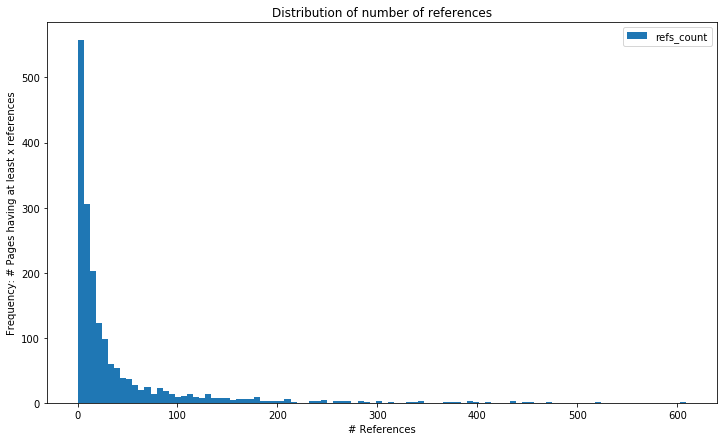

In [70]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references')
plt.show()

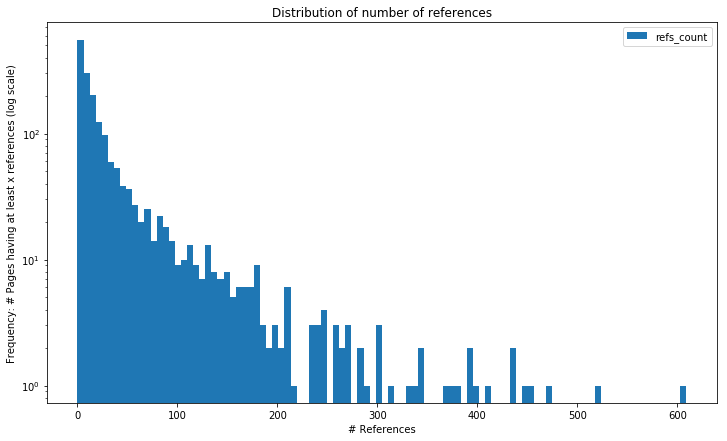

In [83]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, log = True,
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references (log scale)')
plt.show()

**Distribution of number of references**: It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many references have at least x pages?

The distribution has a heavy-tailed distribution: they may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If they follow a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data.

### Get the domains of references

In [63]:
references_rrd = wikipedia.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(5)

+--------+---------+--------------------+--------------------+
|      id| template|               title|                 url|
+--------+---------+--------------------+--------------------+
|29393333| cite web|Population of the...|https://www.censu...|
|29393333|cite book|Cincinnati: From ...|https://books.goo...|
|29393333|cite book|Contested Terrain...|https://books.goo...|
|29393333| cite web|       Irish Ohioans|http://www.ohiohi...|
|29393333|cite book|Frontiers of Free...|https://books.goo...|
+--------+---------+--------------------+--------------------+
only showing top 5 rows



**URL parsing** 
Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [64]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('books.google.com', 1377),
 ('www.nytimes.com', 1293),
 ('www.theguardian.com', 1136),
 ('www.reuters.com', 1114),
 ('www.bbc.co.uk', 943),
 ('www.bbc.com', 678),
 ('news.bbc.co.uk', 660),
 ('www.aljazeera.com', 599),
 ('www.washingtonpost.com', 591),
 ('www.telegraph.co.uk', 482),
 ('edition.cnn.com', 400),
 ('www.cnn.com', 384),
 ('www.jpost.com', 324),
 ('www.independent.co.uk', 287),
 ('twitter.com', 284),
 ('www.haaretz.com', 271),
 ('timesofindia.indiatimes.com', 228),
 ('www.hurriyetdailynews.com', 208),
 ('www.thehindu.com', 208),
 ('abcnews.go.com', 207),
 ('news.yahoo.com', 201),
 ('www.wsj.com', 198),
 ('www.foxnews.com', 194),
 ('www.timesofisrael.com', 188),
 ('www.almasdarnews.com', 185),
 ('english.ahram.org.eg', 184),
 ('www.youtube.com', 183),
 ('www.latimes.com', 182),
 ('www.ynetnews.com', 176),
 ('www.google.com', 171)]

In [65]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 43809


In [66]:
def percentage(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]*100/number_links)

domains_distribution = sqlContext.createDataFrame(domains_count.map(percentage)).sort("count", ascending=False)
domains_distribution.show()

+-----+--------------------+-------------------+
|count|              domain|               perc|
+-----+--------------------+-------------------+
| 1377|    books.google.com| 3.1431897555296855|
| 1293|     www.nytimes.com| 2.9514483325344107|
| 1136| www.theguardian.com| 2.5930744824122898|
| 1114|     www.reuters.com|  2.542856490675432|
|  943|       www.bbc.co.uk|  2.152525736720765|
|  678|         www.bbc.com| 1.5476271998904334|
|  660|      news.bbc.co.uk| 1.5065397521057318|
|  599|   www.aljazeera.com| 1.3672989568353535|
|  591|www.washingtonpos...| 1.3490378689310416|
|  482| www.telegraph.co.uk| 1.1002305462347919|
|  400|     edition.cnn.com|  0.913054395215595|
|  384|         www.cnn.com| 0.8765322194069711|
|  324|       www.jpost.com| 0.7395740601246319|
|  287|www.independent.c...| 0.6551165285671894|
|  284|         twitter.com| 0.6482686206030724|
|  271|     www.haaretz.com| 0.6185943527585656|
|  228|timesofindia.indi...| 0.5204410052728892|
|  208|www.hurriyetd

In [67]:
domains_distribution_pd = domains_distribution.toPandas().set_index('domain')

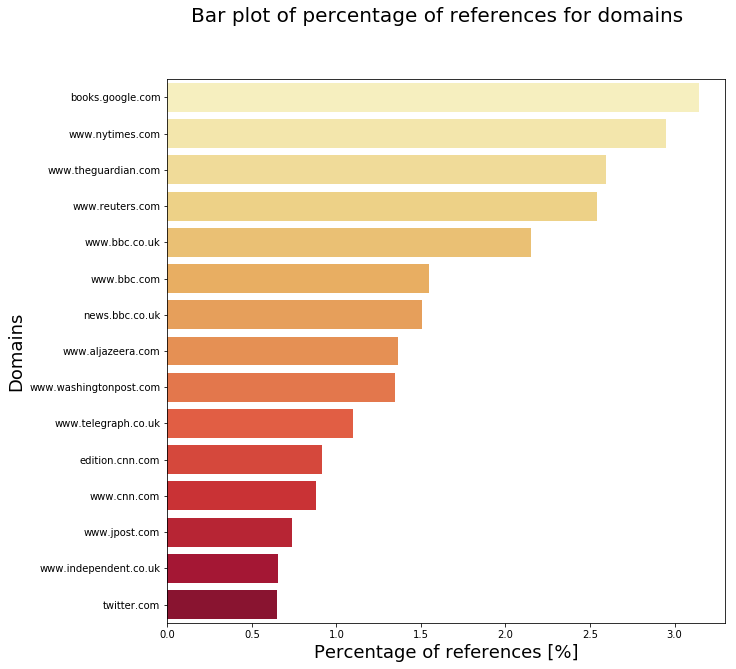

In [68]:
domains_distribution_pd20 = domains_distribution_pd.head(15)

# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd20['perc'], domains_distribution_pd20.index, palette="YlOrRd", ax=ax1, orient='h')
plt.xlabel('Percentage of references [%]',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of percentage of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

# Popularity metric 2

### Get number of views per page

A way of measuring the popularity of a page can be done by looking at the number of views per page. Let's follow the trend!

# Popularity metric 3

### Get number of external links per page





# Popularity metric 3

### Get length of article 
We assume that the longer the article, the more popular it may be.

In [81]:
# Loading the data
DATA_DIR = '../' 
WIKIPEDIA_LENGTH_PARQUET = DATA_DIR + "wikipedia_no_outliers.parquet"

# loading the saved parquet files
articles = spark.read.parquet(WIKIPEDIA_LENGTH_PARQUET)
articles_length = articles.withColumn('article_lenght', F.length(articles.revision.text._VALUE))
articles_length_filter = articles_length.select("id","title","categories","article_lenght")
articles_length_filter.sort('article_lenght', ascending=False).show(5)

+--------+--------------------+-----------------+--------------+
|      id|               title|       categories|article_lenght|
+--------+--------------------+-----------------+--------------+
| 3030955|    Kashmir conflict|military conflict|        364091|
|43243199|2014 Israel–Gaza ...|military conflict|        293156|
| 3177125|Springfield race ...|  civilian attack|        274021|
|39543021|2013–14 Bulgarian...|   civil conflict|        256709|
|41979235|2014 Ukrainian re...|   Civil Conflict|        252912|
+--------+--------------------+-----------------+--------------+
only showing top 5 rows



---

# Joining tables on the page id

Having defined popularity metrics and importance criterion, we now join the tables on the page ID.

## 1. Join all popularity tables on page id

In [85]:
# need tables reference_count_page & articles_length_filter
references_popularity = reference_count_page.registerTempTable('references_popularity')
length_popularity = articles_length_filter.registerTempTable('length_popularity')

query_join_popularity = """
select length_popularity.id, length_popularity.title, length_popularity.categories, length_popularity.article_lenght
from length_popularity
join references_popularity
on length_popularity.id = references_popularity.id
"""

popularity = spark.sql(query_join_popularity)
popularity.show(5)

+--------+--------------------+-----------------+--------------+
|      id|               title|       categories|article_lenght|
+--------+--------------------+-----------------+--------------+
|25523989|      Dongo conflict|military conflict|         11478|
|29393333|Cincinnati riots ...|   civil conflict|         14045|
|29398957| Helwan riots (1945)|   civil conflict|          7679|
|29410468|Cincinnati riots ...|   civil conflict|          5373|
|29412323|Ming–Turpan conflict|military conflict|          8590|
+--------+--------------------+-----------------+--------------+
only showing top 5 rows



In [ ]:
## 2. Join all popularity tables on page id